# Correlation and Cointigration for all stocks 

1. Read data for the financial sector from Yahoo Finance 
2. Create a dataframe which only takes the Adjusted Closing price of the stocks from the entire nested dataframe 
3. Form a correlation matrix for the Adjusted Closing prices of the stocks
4. Find the cointigration matrix for the Adjusted closing prices of the stocks 
    1. This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.
5. Find the pairs that are highly correlated and highly cointigrated
    1. This means that the time series movements are based off of one another
    2. A linear combination of the time series results in a stationary time series

In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import yfinance as yf
import random

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

In [2]:
import random
random.seed(30)

In [3]:
financial_list = "BRK-A V JPM BAC BLK RY-PT GS-PJ PGR USB-PH PNC ALIZF MS-PK CB CRZBY GL SNMYF MORN PAX NAVI ETY SBCF"

In [4]:
len(financial_list)

99

In [5]:
list_tickers = financial_list.split()
len(list_tickers)

21

In [6]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

end = datetime.now().date()
start = (datetime.now() - relativedelta(years=1)).date()

print(start, end)

2021-10-23 2022-10-23


In [7]:
df = yf.download(list_tickers, start=start, end=end, progress = False, group_by="ticker") 
df.dropna(axis = 1, inplace = True)

list_tickers = []
for i in df.columns:
    if i[0] not in list_tickers:
        list_tickers.append(i[0])
    else:
        continue
df.head()

NAVI                                                       \
                 Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2021-10-25  20.030001  20.280001  19.860001  19.870001  19.127438   997500   
2021-10-26  19.840000  19.969999  19.520000  19.600000  18.867527  2046500   
2021-10-27  19.870001  19.870001  19.180000  19.200001  18.482477  1949200   
2021-10-28  19.379999  19.540001  19.020000  19.459999  18.732759  1424100   
2021-10-29  19.480000  19.770000  19.459000  19.700001  18.963791  1949200   

                   BLK                                      ...         PNC  \
                  Open        High         Low       Close  ...         Low   
Date                                                        ...               
2021-10-25  918.539978  931.929993  912.020020  924.739990  ...  215.509995   
2021-10-26  933.539978  938.929993  928.349976  931.580017  ...  215.369995   
2021-10-27  930.190002  939.349976  916.590027  917.270020  ...  212.770004   
2021-10-28  916.239990  935.830017  916.239990  935.479980  ...  212.330002   
2021-10-29  930.979980  947.859985  930.559998  943.460022  ...  210.410004   

                                                   BAC                        \
                 Close   Adj Close   Volume       Open       High        Low   
Date                                                                           
2021-10-25  216.559998  209.533875  2124100  47.799999  47.980000  47.200001   
2021-10-26  216.070007  209.059769  1281400  47.660000  48.430000  47.439999   
2021-10-27  212.910004  206.002304  1512500  47.480000  48.169998  47.029999   
2021-10-28  213.050003  206.137756  1440300  47.590000  48.000000  47.299999   
2021-10-29  211.029999  204.183273  1776700  47.750000  48.130001  47.520000   

                                            
                Close  Adj Close    Volume  
Date                                        
2021-10-25  47.509998  46.476681  31679500  
2021-10-26  47.959999  46.916897  35674800  
2021-10-27  47.040001  46.016907  45790800  
2021-10-28  47.779999  46.740807  37209600  
2021-10-29  47.779999  46.740807  31756200  

[5 rows x 126 columns]

In [8]:
df_adjclose = pd.DataFrame()

In [9]:
type(df["GS-PJ"]["Adj Close"])

pandas.core.series.Series

In [10]:
# Create empty dataframe to store req column
df_adjcloseall = pd.DataFrame()

# Get adjusted closing price for tickers
for i in range(len(list_tickers)):
    # Series
    df_adjclose = df[list_tickers[i]]['Adj Close']
    
    # Converting that to dataframe
    df_adjclose = pd.DataFrame(data = df_adjclose)
    
    # Renaming Adj Close to ticker name 
    df_adjclose.rename(columns = {'Adj Close':list_tickers[i]}, inplace = True)
    
    # Concatenating a column to the main dataframe (with all adj close)
    df_adjcloseall = pd.concat([df_adjcloseall, df_adjclose], axis=1)

#df_adjcloseall

Text(0.5, 1.0, 'Assets Correlation Matrix')

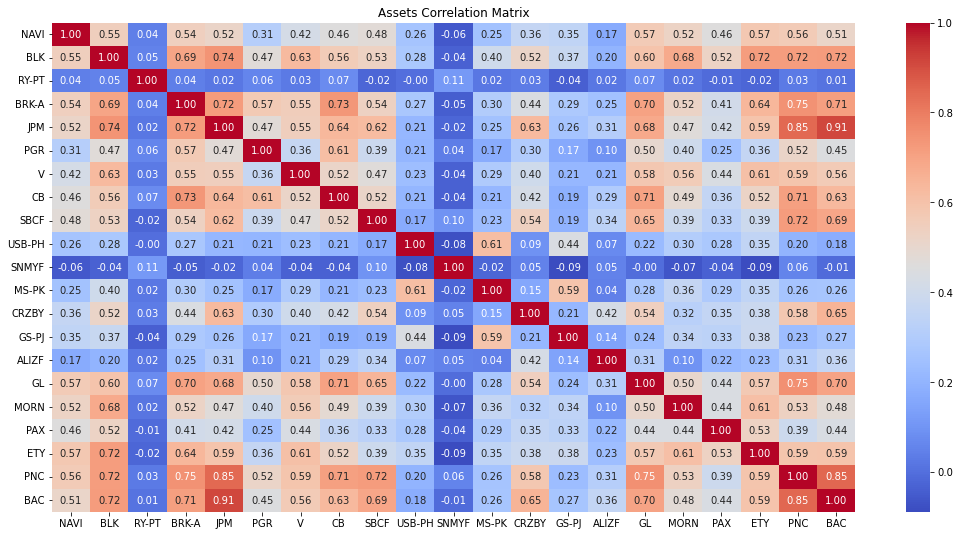

In [11]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(18,9))

sns.heatmap(df_adjcloseall.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman

ax.set_title('Assets Correlation Matrix')

In [12]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    # The number of columns
    n = data.shape[1]
    
    # Square matrix with ones with size of columns
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]]) # using the coint function to calculate co-integrated pairs
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs



# calculate p-values and plot as a heatmap

pvalues, cointegrated_pairs = find_cointegrated_pairs(df_adjcloseall)

print(cointegrated_pairs)

[('NAVI', 'BLK'), ('NAVI', 'USB-PH'), ('NAVI', 'MS-PK'), ('NAVI', 'MORN'), ('BLK', 'USB-PH'), ('BLK', 'MS-PK'), ('RY-PT', 'BRK-A'), ('RY-PT', 'JPM'), ('RY-PT', 'PGR'), ('RY-PT', 'V'), ('RY-PT', 'CB'), ('RY-PT', 'SBCF'), ('RY-PT', 'USB-PH'), ('RY-PT', 'SNMYF'), ('RY-PT', 'MS-PK'), ('RY-PT', 'CRZBY'), ('RY-PT', 'GS-PJ'), ('RY-PT', 'ALIZF'), ('RY-PT', 'GL'), ('RY-PT', 'MORN'), ('RY-PT', 'PAX'), ('RY-PT', 'ETY'), ('RY-PT', 'PNC'), ('RY-PT', 'BAC'), ('PGR', 'MORN'), ('V', 'SBCF'), ('V', 'SNMYF'), ('V', 'ALIZF'), ('V', 'PAX'), ('V', 'ETY'), ('SBCF', 'USB-PH'), ('SBCF', 'SNMYF'), ('SBCF', 'MS-PK'), ('SBCF', 'ALIZF'), ('SBCF', 'MORN'), ('SBCF', 'PAX'), ('SBCF', 'ETY'), ('SBCF', 'PNC'), ('SBCF', 'BAC'), ('USB-PH', 'MS-PK'), ('SNMYF', 'MS-PK'), ('SNMYF', 'CRZBY'), ('SNMYF', 'GS-PJ'), ('SNMYF', 'ALIZF'), ('SNMYF', 'GL'), ('SNMYF', 'MORN'), ('SNMYF', 'PAX'), ('SNMYF', 'ETY'), ('SNMYF', 'PNC'), ('SNMYF', 'BAC'), ('MS-PK', 'MORN'), ('CRZBY', 'GS-PJ'), ('CRZBY', 'ALIZF'), ('CRZBY', 'GL'), ('CRZBY', '

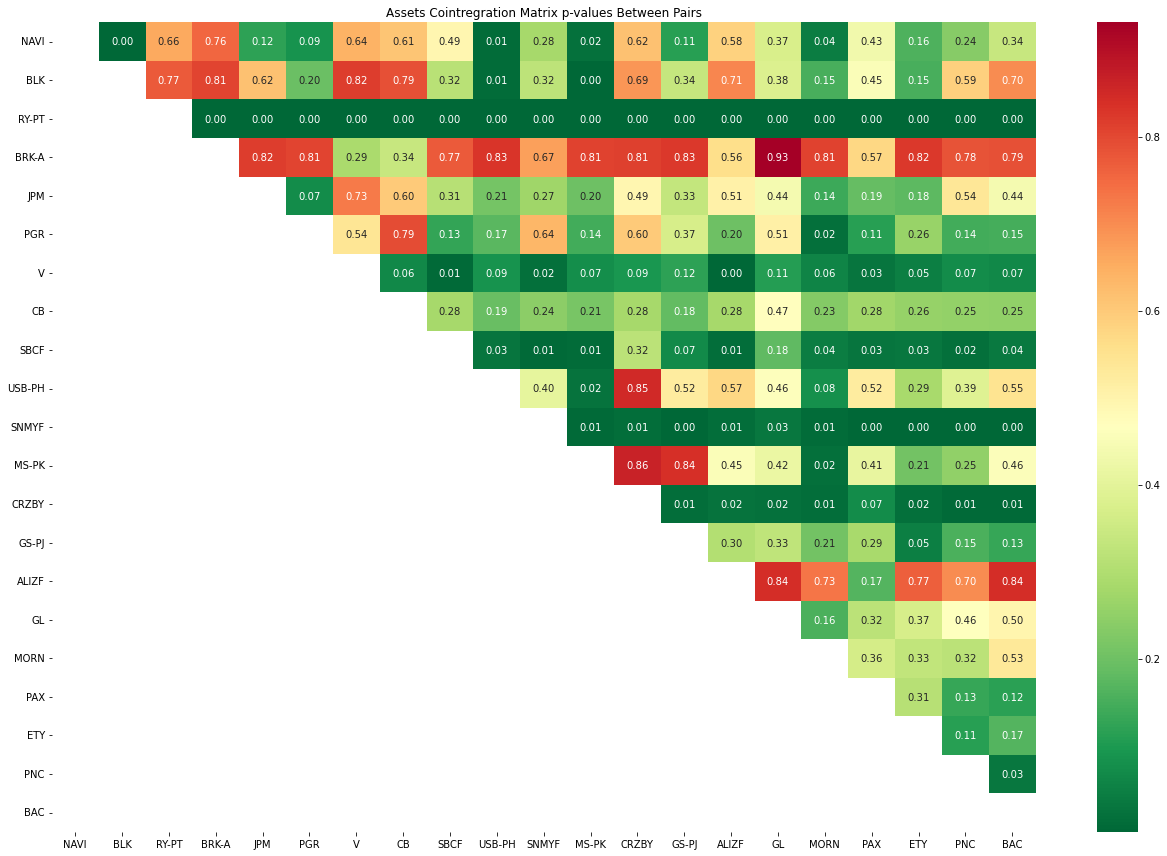

In [13]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(pvalues, xticklabels = df_adjcloseall.columns,
                yticklabels = df_adjcloseall.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()

# Rules for hypothesis testing for co-integration

_Ho: There is no cointegration_

_H1: Cointegration exists_

_If p-value plotted in the heatmap < 0.05, we fail to accept the null hypothesis_

# FINDING CORRELATED AND COINTEGRATED PAIRS

In [15]:
corr = df_adjcloseall.pct_change().corr(method ='pearson').unstack()
correlated_indices = []


for i in range(len(corr)):
    if corr[i] < 0.5 or corr[i] == 1:
        continue
    else:
        correlated_indices.append(i)
        
        
correlated_pairs = []
counter = 0
for i in corr.index:
    if counter in correlated_indices:
        correlated_pairs.append(i)
    counter = counter + 1

In [16]:
corr_coin_pairs = list(set(cointegrated_pairs).intersection(correlated_pairs))

In [17]:
corr_coin_pairs

[('SBCF', 'PNC'),
 ('NAVI', 'MORN'),
 ('PNC', 'BAC'),
 ('CRZBY', 'PNC'),
 ('CRZBY', 'GL'),
 ('NAVI', 'BLK'),
 ('SBCF', 'BAC'),
 ('V', 'ETY'),
 ('USB-PH', 'MS-PK'),
 ('CRZBY', 'BAC')]